# BERTopic Advanced Methods

The key idea behind most advanced methods is leveraging some kind of prior knowledge about the data, or generating such on the fly.

In [7]:
import json
from random import randint
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from helper.ConfusionLoss import confusion_loss_from_labels
import matplotlib.pyplot as plt


## Partial Labels

If you have partially labeled data, e.g. because you annotated a sample of your corpus, you can use this information to improve the topic modeling results.
By providing BERTopic with these labels, you can steer the dimensionality reduction step into paying more attention to those dimensions, that are important to distingiush between your labels.

![Semi Supervised Clustering](../assets/graphics/bertopic-overview-semi-supervised.png)

BERTopic calls this **Semi-Supervised** Topic Modeling.

For demonstration purposes, we will use part of the ground-truth labels to demonstrate how this works.
First, we assign an index to each topic we want to use. Next, we construct an array of topic-indicies that has to be the same length as the number of documents in the corpus. Every unlabeled document will receive `-1` as its label.

In [3]:
with open('../data/articles/test.json') as f:
    data = json.load(f)
    texts = [article['text'] for article in data]
    labels = [article['label'] for article in data]

label_idx_map = {label: idx for idx, label in enumerate(set(labels))}
label_indices = [label_idx_map[label] for label in labels]


def rand(p=.1):
    return randint(0, 100) < p * 100


partial_labels = [idx if rand(.1) else -1 for idx in label_indices]


We hand these labels to BERTopic by providing the `y` parameter in the fit function.

In [15]:
bertopic = BERTopic(verbose=True)
model = bertopic.fit(texts, y=partial_labels)


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-06-14 15:42:18,761 - BERTopic - Transformed documents to Embeddings
2023-06-14 15:42:21,537 - BERTopic - Reduced dimensionality
2023-06-14 15:42:21,553 - BERTopic - Clustered reduced embeddings


To check the quality of topics, we will employ our confusion-loss metric.

Confusion loss: 0.3725280530912319


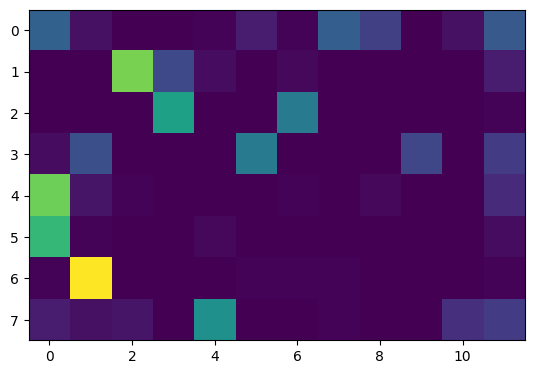

In [31]:
score, conf_matrix = confusion_loss_from_labels(labels, model.topics_)

print(f'Confusion loss: {score}')
plt.imshow(conf_matrix)


In [27]:
model.visualize_hierarchy()


### Improving Topic Descriptions

Here, we encounter a problem. *the*, *and*, and *to* appear in a lot of topic descriptions, despite being typical stop-words. Especially when working with a small corpus, this can happen. To avoid this, we can fine-tune the `vectorizer`, which is used to derive topic descriptions. Note, that this has no influence whatsoever on the topic modeling itself.

In [23]:
vectorizer_model = CountVectorizer(stop_words="english")
bertopic_stopwords = BERTopic(verbose=True, vectorizer_model=vectorizer_model)
model_stopwords = bertopic_stopwords.fit(texts, y=partial_labels)


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-06-14 15:50:49,037 - BERTopic - Transformed documents to Embeddings
2023-06-14 15:50:51,864 - BERTopic - Reduced dimensionality
2023-06-14 15:50:52,060 - BERTopic - Clustered reduced embeddings


In [24]:
model_stopwords.visualize_hierarchy()


## Seed Topics

If, instead of having partial labels, you have an idea of what the topics should be, you can employ seed topics. These are topics that you provide to BERTopic as keywords, which will then try to find similar topics in the corpus.

BERTopic does not neccecarily keep these topics fixed, but rather uses them as a starting point for the topic modeling process. This is also called **guided** topic modeling.

![Guided Topic Modeling](../assets/graphics/bertopic-overview-guided.png)

Guided Topic Modeling works very similar to semi-supervised topic modeling. Instead of providing labels, we provide keywords. Using the same embedding-mechanism as for the documents, these keywords are then projected into the embeddings-space.

In turn, the documents that are closest to these topic-embeddings are annotated with the respective topic. With these labels, BERTopic continues with its semi-supervised pipeline.

When creating the topic descriptions, BERTopic will apply more weight to those words that are also present in the seed topics. This way, we can ensure that the topics appear similar to the seed topics.

To perform guided topic modeling, we provide the `seed_topics` parameter to the constructor.

In [4]:
seed_topics = [["economy"], ["sports"]]

vectorizer_model = CountVectorizer(stop_words="english")
bertopic_seeded = BERTopic(
    verbose=True, seed_topic_list=seed_topics, vectorizer_model=vectorizer_model)
model_seeded = bertopic_seeded.fit(texts)


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-06-14 18:39:40,013 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 18:39:46,919 - BERTopic - Reduced dimensionality
2023-06-14 18:39:46,938 - BERTopic - Clustered reduced embeddings


In [5]:
model_seeded.visualize_hierarchy()


Confusion loss: 0.38809896369100727


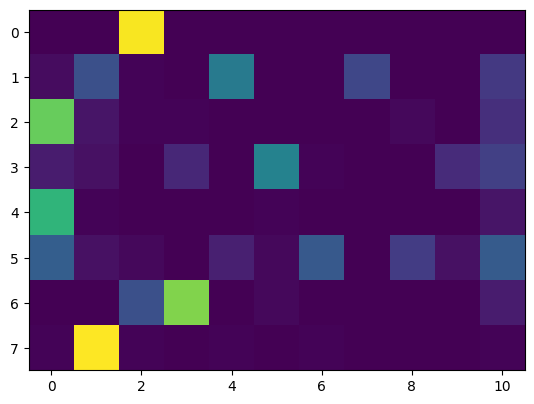

In [8]:
score, conf_matrix = confusion_loss_from_labels(labels, model_seeded.topics_)

print(f'Confusion loss: {score}')
plt.imshow(conf_matrix)
